# Data / Feature engineering Notebook
This notebook's purpose is to show how one might:

1. Pull some data in. Validate a schema.
2. Process it.
3. Save it.

Using feature engineering as the context. The transforms here are not complex, but hopefully illustrative of how one might use Hamilton in this context.


# Notebook setup


In [1]:
from IPython.display import clear_output

Uncomment and run the cell below if you are in a Google Colab environment. It will:

1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the example
7. Install requirements.
8. This means that any modifications will be saved, and you won't lose them if you close your browser.

In [2]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton-tutorials/
## 6. Move your current directory to the example
# %cd hamilton-tutorials/2023-10-09/credit_card_approval
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

In [3]:
import os
import numpy as np
import pandas as pd
from hamilton import driver, base
from hamilton.function_modifiers import source
from IPython.display import display

# Use autoreload to automatically reload our function modules
%load_ext autoreload
%autoreload 1

DAGWORKS_API_KEY = os.environ["DAGWORKS_STAGING_API_KEY"]
DAGWORKS_PROJECT_ID = 3
DAGWORKS_PROJECT_EMAIL = "stefan@dagworks.io"

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Write the code to load data
The following code defines creating a dataframe and validating its schema.

There is no "data joining" here really, but you could go to a SQL database, or many files, etc., and perform the joins you want on data and then pull that into memory for Hamilton to then operate over.

Note: you need to manage indexes/row alignment when processing. With Pandas this manifests itself as setting the right indexes when you load data.

Note: it uses @config.when to switch how data is loaded.

In [4]:
%%writefile data_loader.py
"""
This module contains our data loading functions.
"""
from typing import List

import pandas as pd
import pandera as pa
from sklearn import datasets

from hamilton.function_modifiers import check_output, config, extract_columns, load_from, source


def _sanitize_columns(df_columns: List[str]) -> List[str]:
    """Renames columns to be valid hamilton names -- and lower cases them.
    :param df_columns: the current column names.
    :return: sanitize column names that work with Hamilton
    """
    return [
        c.strip().replace(".", "_").replace("/", "_per_").replace(" ", "_").lower()
        for c in df_columns
    ]


# schema to validate against
passengers_df_schema = pa.DataFrameSchema(
    {
        "pclass": pa.Column(int, nullable=False),
        # "pclass": pa.Column(float, nullable=False),  # swap this for the above to fail/warn
        "sex": pa.Column(str, nullable=False),
        "age": pa.Column(float, nullable=True),
        "parch": pa.Column(int, nullable=False),
        "sibsp": pa.Column(int, nullable=False),
        "fare": pa.Column(float, nullable=True),
        "embarked": pa.Column(str, nullable=True),
        "name": pa.Column(str, nullable=False),
        "ticket": pa.Column(str, nullable=False),
        "boat": pa.Column(str, nullable=True),
        "body": pa.Column(float, nullable=True),
        "home_dest": pa.Column(str, nullable=True),
        "cabin": pa.Column(str, nullable=True),
        "survived": pa.Column(pa.dtypes.Category, nullable=False),
    },
    strict=True,
)


@config.when(loader="openml")
def raw_passengers_df__openml() -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    base, targets = datasets.fetch_openml("titanic", parser='auto', version=1, as_frame=True, return_X_y=True)
    df = pd.concat([base, targets], axis=1)
    return df


@config.when(loader="parquet")
@load_from.csv(path=source("titanic_dataset_path"))
def raw_passengers_df__parquet(raw_passengers: pd.DataFrame) -> pd.DataFrame:
    """Pulls data from the web. Only becomes a node in the DAG if `openml` is specified.

    :return: dataframe of data.
    """
    return raw_passengers


@extract_columns("pclass", "sex", "age", "parch", "sibsp", "fare", "embarked", "name", "survived")
@check_output(schema=passengers_df_schema, target_="passengers_df", importance="fail")
def passengers_df(raw_passengers_df: pd.DataFrame) -> pd.DataFrame:
    """Function to take in a raw dataframe, check the output, and then extract columns.

    :param raw_passengers_df: the raw dataset we want to bring in.
    :return:
    """
    raw_passengers_df = raw_passengers_df.dropna(subset=["embarked"])
    raw_passengers_df.columns = _sanitize_columns(raw_passengers_df.columns)
    return raw_passengers_df


def target(survived: pd.Series) -> pd.Series:
    """Just hard coding this mapping that we want survived to be our target.

    :param survived:
    :return:
    """
    target_col = survived.copy()
    target_col.name = "target"
    return target_col


Overwriting data_loader.py


In [5]:
# load the data_loader and setup autoreloading
%aimport data_loader

# Load from openml
Here we have a driver that loads data from openml.

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


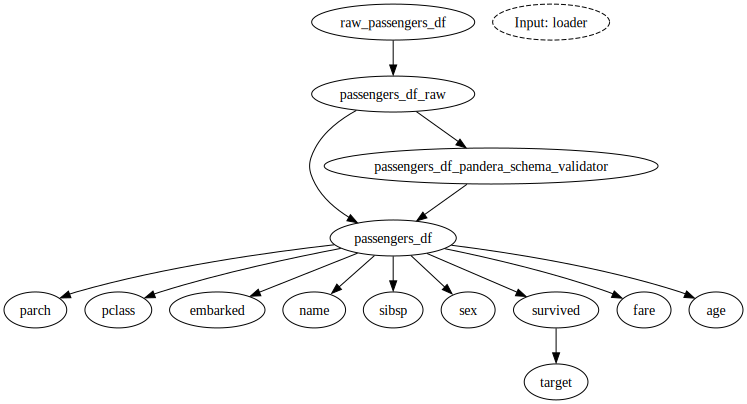

In [6]:
config = {"loader": "openml"}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Load from Parquet
Here we have a driver that loads data from parquet. Note it requires an extra input to operate.

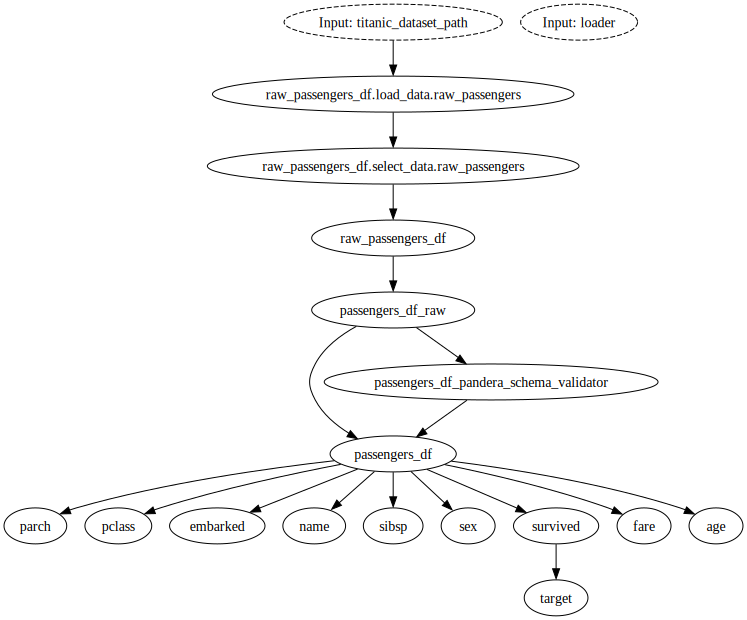

In [7]:
config = {"loader": "parquet"}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Load it yourself
When no value is passed that matches @config nodes -- they disappear. In this particular context we can then pass in a dataframe at execution time.

The point here is that without having to change the code, we can swap out different modalities of how data is provided easily. Which is a common cause of technical debt because you couple how data is loaded.

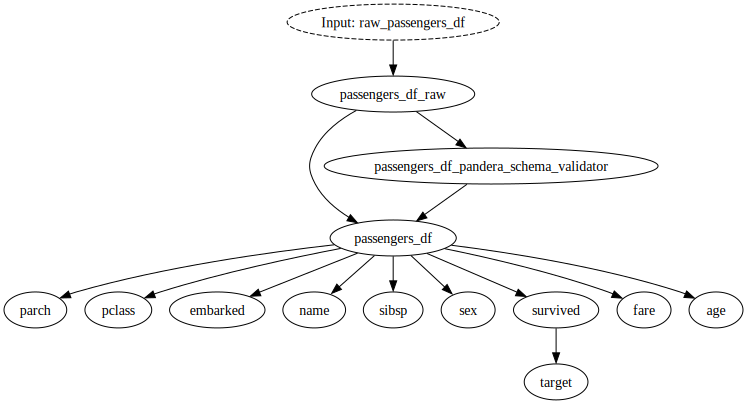

In [8]:
config = {}
dr = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Let's "load the data"
Let's run the dataflow and talk about saving artifacts.

A few things to note:
1. You can get any intermediate node as output in Hamilton.
2. There are two means to execute a driver. `.execute()` and `.materialize()`.
3. `.execute()` is a way to "fix" what is created/returned when execute is called.
4. `.materialize()` allows more flexiblity to add/adjust what and how is returned, but "injecting" nodes into the dataflow.

Let's see the code. First using `.execute()` and then `.materialize()`.

In [9]:

config = {"loader": "openml"}
driver_1 = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .with_adapter(base.DefaultAdapter())
        .build()# .execute() will return a dictionary
    )

driver_2 = (
        driver.Builder()
        .with_modules(data_loader)
        .with_config(config)
        .with_adapter(base.SimplePythonDataFrameGraphAdapter())
        .build()# .execute() will return dataframe
    )
# can use functions or string names:
outputs = ["pclass", "sibsp", "age", "name", "parch", data_loader.target]

dict result:
 dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])
0    29.0000
1     0.9167
2     2.0000
3    30.0000
4    25.0000
df result: 
    pclass  sibsp      age                                             name  parch target
0       1      0  29.0000                    Allen, Miss. Elisabeth Walton      0      1
1       1      1   0.9167                   Allison, Master. Hudson Trevor      2      1
2       1      1   2.0000                     Allison, Miss. Helen Loraine      2      0
3       1      1  30.0000             Allison, Mr. Hudson Joshua Creighton      2      0
4       1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)      2      0


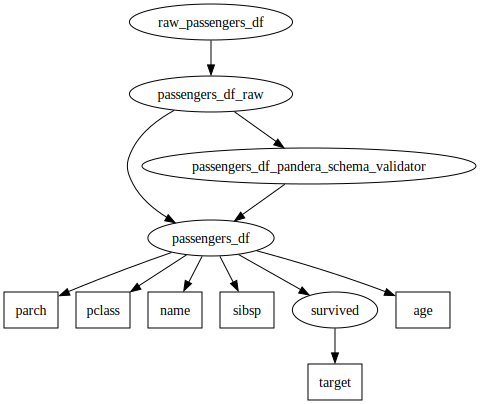

In [10]:
# Using .execute()
result_dict = driver_1.execute(outputs)
# we got a dictionary back
print("dict result:\n", result_dict.keys())
print(result_dict["age"].head().to_string())

# we got a dataframe back -- uses index to stitch it all together.
result_df = driver_2.execute(outputs)
print("df result: \n", result_df.head().to_string())

# note: this is what execution looks like for both
driver_1.visualize_execution(outputs)

{}
dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])


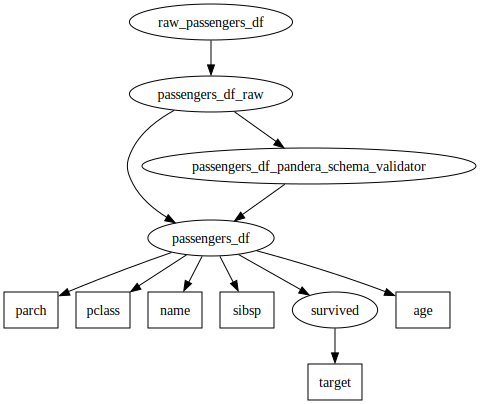

In [11]:
# Using .materialize() -- basic; no materializers

# how to get the same as .execute() with a dictionary adapter:
metadata, dict_outputs = driver_2.materialize(additional_vars=outputs)
print(metadata)
print(dict_outputs.keys())
driver_2.visualize_materialization(additional_vars=outputs)

dict_keys(['output_df'])
dict_keys(['pclass', 'sibsp', 'age', 'name', 'parch', 'target'])


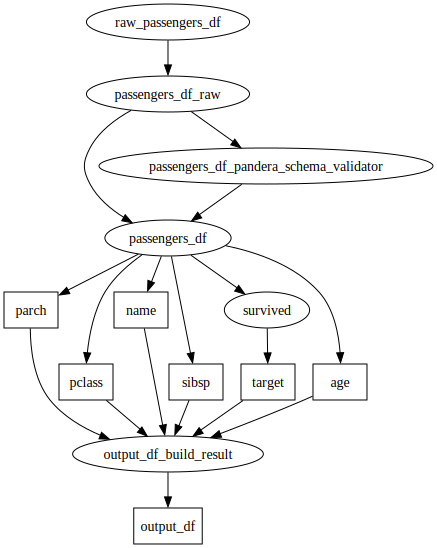

In [12]:
# Using .materialize() -- basic; emulate getting a dataframe in memory & a dictionary...
from hamilton.io.materialization import to

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = driver_2.materialize(
       *materializers, additional_vars=outputs)
print(metadata.keys())
print(dict_outputs.keys())
driver_2.visualize_materialization(*materializers, additional_vars=outputs)

{'output_df':       pclass  sibsp      age                                             name  \
0          1      0  29.0000                    Allen, Miss. Elisabeth Walton   
1          1      1   0.9167                   Allison, Master. Hudson Trevor   
2          1      1   2.0000                     Allison, Miss. Helen Loraine   
3          1      1  30.0000             Allison, Mr. Hudson Joshua Creighton   
4          1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...    ...      ...                                              ...   
1304       3      1  14.5000                             Zabour, Miss. Hileni   
1305       3      1      NaN                            Zabour, Miss. Thamine   
1306       3      0  26.5000                        Zakarian, Mr. Mapriededer   
1307       3      0  27.0000                              Zakarian, Mr. Ortin   
1308       3      0  29.0000                               Zimmerman, Mr. Leo   

      parch t

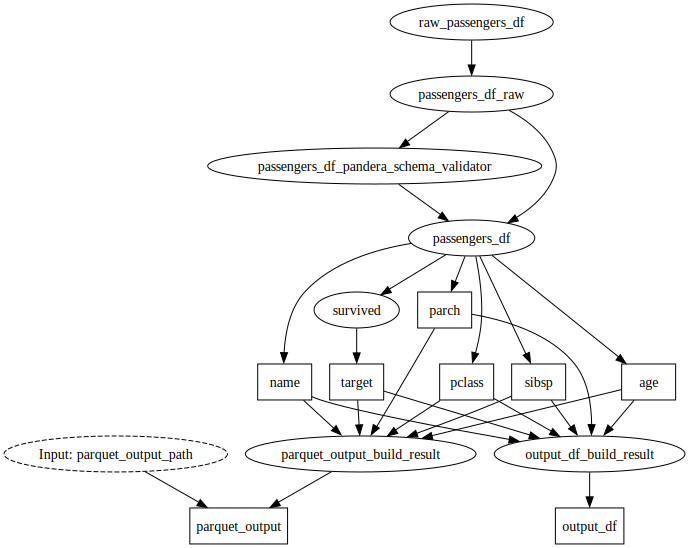

In [13]:
# .materializer but actually save the result -- we can just add to the materializer list!

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="parquet_output",
        path=source("parquet_output_path"),
        dependencies=outputs,
        combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = driver_2.materialize(
      *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"})
print(metadata)
print(dict_outputs.keys())
driver_2.visualize_materialization(
    *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"})

# Add DAGWorks
To get a lot more introspection, etc. We just need to switch out the driver.

In [15]:

from dagworks import driver as dw_driver
dw_dr = dw_driver.Driver(
   config,
   data_loader,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading",
   tags={"env": "local", "where": "notebook"}
)

# .materializer but actually save the result -- we can just add to the materializer list!

materializers = [
    to.memory(
     id="output_df",
     dependencies=outputs,
     combine=base.PandasDataFrameResult()
    ),
    to.parquet(
        id="parquet_output",
        path=source("parquet_output_path"),
        dependencies=outputs,
        combine=base.PandasDataFrameResult()
    )
]
# get the dictionary & the dataframe back at the same time!
metadata, dict_outputs = dw_dr.materialize(
      *materializers,
    additional_vars=outputs,
    inputs={"parquet_output_path": "temp_feature_output.parquet"})
print(metadata)
print(dict_outputs.keys())
# Go see it in the UI -- see the URL in the output.


Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1082



{'output_df':       pclass  sibsp      age                                             name  \
0          1      0  29.0000                    Allen, Miss. Elisabeth Walton   
1          1      1   0.9167                   Allison, Master. Hudson Trevor   
2          1      1   2.0000                     Allison, Miss. Helen Loraine   
3          1      1  30.0000             Allison, Mr. Hudson Joshua Creighton   
4          1      1  25.0000  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...    ...      ...                                              ...   
1304       3      1  14.5000                             Zabour, Miss. Hileni   
1305       3      1      NaN                            Zabour, Miss. Thamine   
1306       3      0  26.5000                        Zakarian, Mr. Mapriededer   
1307       3      0  27.0000                              Zakarian, Mr. Ortin   
1308       3      0  29.0000                               Zimmerman, Mr. Leo   

      parch t

# Now let's transform the data
How should we think about extending what we've done? Simple. Just add nodes & edges!

Reminder: the contract you need to fulfill is that functions that depend on what was loaded, just need to declare a parameter with the corresponding name & type.

With this in mind, we can create an independent module, that isn't coupled to this initial dataset, other than being coupled via "naming" of the outputs mapping to inputs. So that's what we'll do below.

The task of the code below is to create a dataset for training, after transforming the data.

In [22]:
%%writefile features.py
"""
This is a module that contains our feature transforms.
"""
import pickle
from typing import Set

import pandas as pd

# from sklearn.preprocessing import OneHotEncoder
from sklearn import impute  # import KNNImputer
from sklearn import preprocessing

from hamilton.function_modifiers import check_output, config


def rare_titles() -> Set[str]:
    """Rare titles we've curated"""
    return {
        "Capt",
        "Col",
        "Don",
        "Dona",
        "Dr",
        "Jonkheer",
        "Lady",
        "Major",
        "Mlle",
        "Mme",
        "Ms",
        "Rev",
        "Sir",
        "the Countess",
    }


@check_output(data_type=int)
def family_size(parch: pd.Series, sibsp: pd.Series) -> pd.Series:
    return parch + sibsp


def normalized_name(name: pd.Series) -> pd.Series:
    """I believe this actually gets the honorific, not the name."""
    return name.apply(lambda x: x.split(",")[1].split(".")[0].strip())


def title(normalized_name: pd.Series, rare_titles: Set[str]) -> pd.Series:
    return normalized_name.apply(lambda n: "rare" if n in rare_titles else n)


def is_alone(family_size: pd.Series) -> pd.Series:
    return (family_size == 1).astype(int)


def one_hot_encoder() -> preprocessing.OneHotEncoder:
    return preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)


@config.when(model_to_use="create_new")
def fit_categorical_encoder__create_new(
    one_hot_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> preprocessing.OneHotEncoder:
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    one_hot_encoder.fit(cat_df)
    return one_hot_encoder


@config.when(model_to_use="use_existing")
def fit_categorical_encoder__use_existing(
    categorical_encoder_path: str,
) -> preprocessing.OneHotEncoder:
    with open(categorical_encoder_path, "rb") as f:
        return pickle.load(f)


def categorical_df(
    fit_categorical_encoder: preprocessing.OneHotEncoder,
    embarked: pd.Series,
    sex: pd.Series,
    pclass: pd.Series,
    title: pd.Series,
    is_alone: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of categorical features.

    The number of "features" output depends on the number of categories.

    :param fit_categorical_encoder:
    :param embarked:
    :param sex:
    :param pclass:
    :param title:
    :param is_alone:
    :return:
    """
    cat_df = pd.concat([embarked, sex, pclass, title, is_alone], axis=1)
    cat_df.columns = cat_df.columns.astype(str)
    cat_df = fit_categorical_encoder.transform(cat_df)
    df = pd.DataFrame(cat_df)
    df.index = embarked.index
    df.columns = [f"categorical_{c}" for c in df.columns]
    return df


def knn_imputer(n_neighbors: int = 5) -> impute.KNNImputer:
    return impute.KNNImputer(n_neighbors=n_neighbors)


@config.when(model_to_use="create_new")
def fit_knn_imputer__create_new(
    knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> impute.KNNImputer:
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    knn_imputer.fit(num_df)
    return knn_imputer


@config.when(model_to_use="use_existing")
def fit_knn_imputer__use_existing(knn_imputer_path: str) -> impute.KNNImputer:
    with open(knn_imputer_path, "rb") as f:
        return pickle.load(f)


def knn_imputed_df(
    fit_knn_imputer: impute.KNNImputer,
    age: pd.Series,
    fare: pd.Series,
    family_size: pd.Series,
) -> pd.DataFrame:
    """This creates the dataframe of KNN imputed numeric features.

    :param fit_knn_imputer:
    :param age:
    :param fare:
    :param family_size:
    :return:
    """
    num_df = pd.concat([age, fare, family_size], axis=1)
    num_df.columns = num_df.columns.astype(str)
    imputed_df = fit_knn_imputer.transform(num_df)
    df = pd.DataFrame(imputed_df)
    df.index = age.index
    df.columns = [f"knn_imputed_{c}" for c in df.columns]
    return df


def robust_scaler() -> preprocessing.RobustScaler:
    return preprocessing.RobustScaler()


@config.when(model_to_use="create_new")
def fit_scaler__create_new(
    robust_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> preprocessing.RobustScaler:
    robust_scaler.fit(knn_imputed_df)
    return robust_scaler


@config.when(model_to_use="use_existing")
def fit_scaler__use_existing(scaler_path: str) -> preprocessing.RobustScaler:
    with open(scaler_path, "rb") as f:
        return pickle.load(f)


def scaled_numeric_df(
    fit_scaler: preprocessing.RobustScaler, knn_imputed_df: pd.DataFrame
) -> pd.DataFrame:
    """This creates the dataframe of scaled numeric features.

    :param fit_scaler:
    :param knn_imputed_df:
    :return:
    """
    num_df = fit_scaler.transform(knn_imputed_df)
    df = pd.DataFrame(num_df)
    df.index = knn_imputed_df.index
    df.columns = [f"scaled_numeric_{c}" for c in df.columns]
    return df


def data_set(
    scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame, target: pd.Series
) -> pd.DataFrame:
    """This function creates our dataset.

    Following what was in the code, this is how the features are stuck together.

    :param scaled_numeric_df:
    :param categorical_df:
    :param target:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df, target], axis=1)


def inference_set(scaled_numeric_df: pd.DataFrame, categorical_df: pd.DataFrame) -> pd.DataFrame:
    """This function creates an inference set.

    :param scaled_numeric_df:
    :param categorical_df:
    :return:
    """
    return pd.concat([scaled_numeric_df, categorical_df], axis=1)


Overwriting features.py


In [18]:
# import for reloading features.py
%aimport features

# Let's independently see the features module!
We can independently run this module very easily.

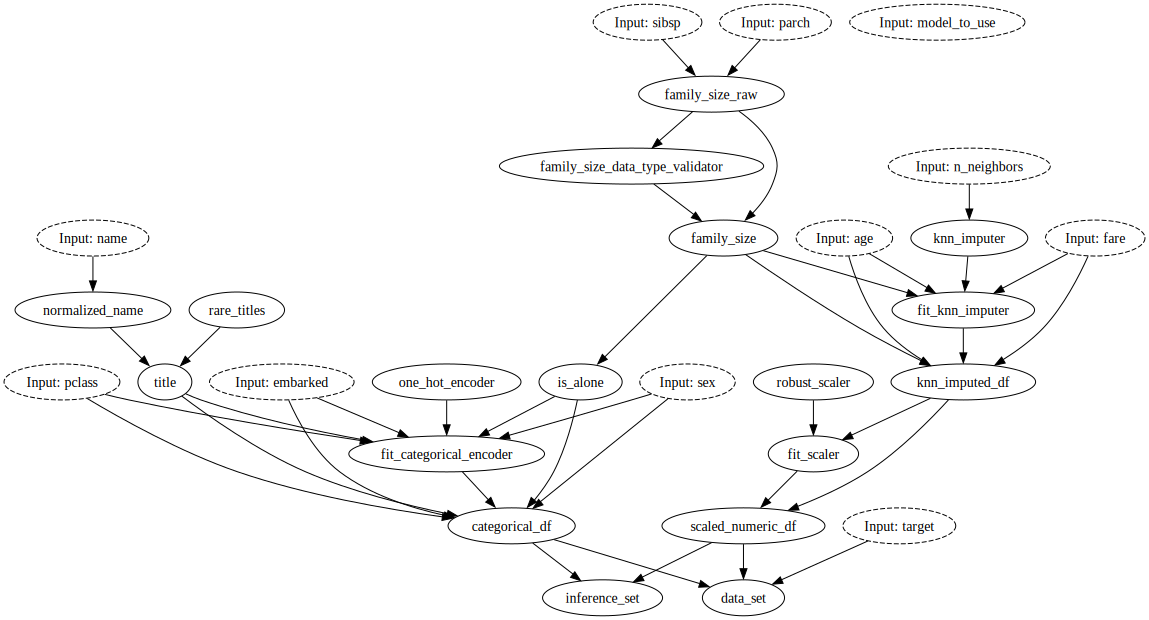

In [19]:
config = {"model_to_use": "create_new"}
dr = (
        driver.Builder()
        .with_modules(features)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Let's connect data loading with features
Just to show composability -- we can now create a larger dataflow, by including more modules!

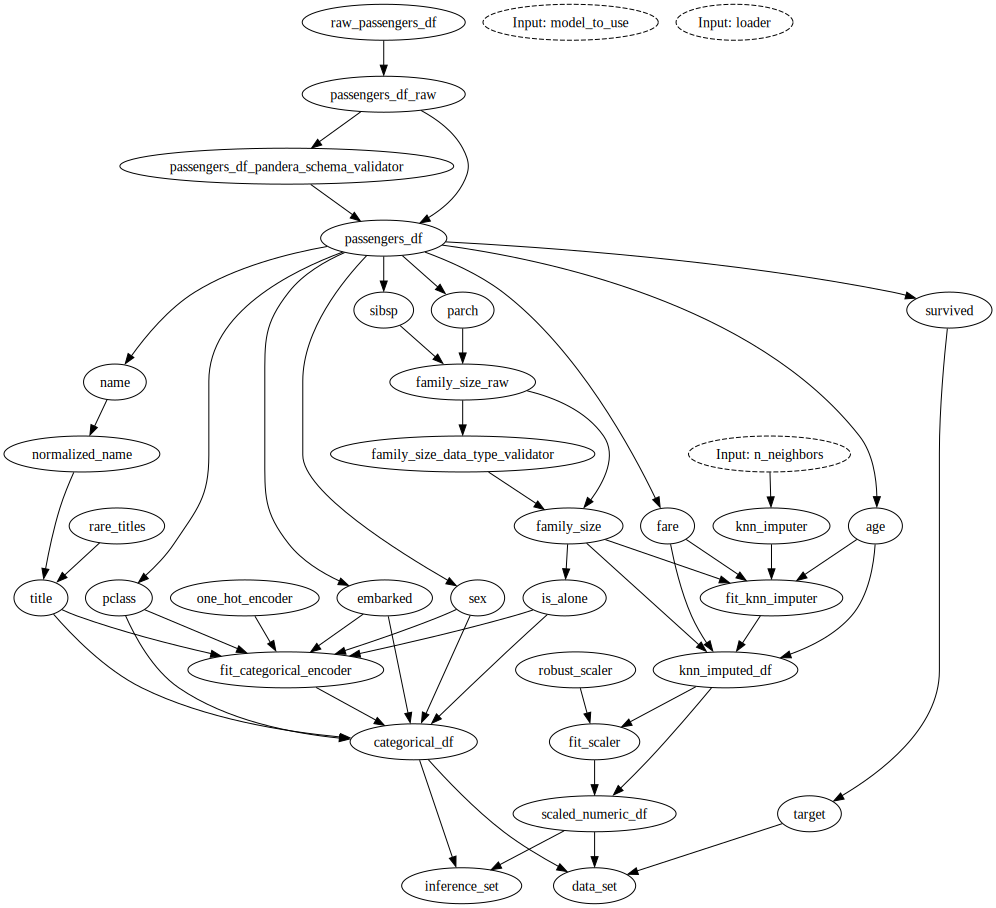

In [24]:
config = {"model_to_use": "create_new", "loader":"openml"}
dr = (
        driver.Builder()
        .with_modules(data_loader, features)
        .with_config(config)
        .build()
    )
dr.display_all_functions()

# Let's actually run it

In [26]:
outputs = [features.inference_set, features.data_set]
materializers = [
    # to.memory(
    #  id="feature_df",
    #  dependencies=outputs,
    #  combine=base.PandasDataFrameResult()
    # ),
]
# just get the data sets without materializing anything.
metadata, dict_outputs = dr.materialize(
      *materializers,
    additional_vars=outputs)
print(metadata)
print(dict_outputs.keys())
print(dict_outputs["inference_set"].head().to_string())
print(dict_outputs["data_set"].head().to_string())

{}
dict_keys(['inference_set', 'data_set'])
   scaled_numeric_0  scaled_numeric_1  scaled_numeric_2  categorical_0  categorical_1  categorical_2  categorical_3  categorical_4  categorical_5  categorical_6  categorical_7  categorical_8  categorical_9  categorical_10  categorical_11  categorical_12  categorical_13  categorical_14
0          0.000000          8.421302               0.0            0.0            0.0            1.0            1.0            0.0            1.0            0.0            0.0            0.0            1.0             0.0             0.0             0.0             1.0             0.0
1         -1.702018          5.864007               3.0            0.0            0.0            1.0            0.0            1.0            1.0            0.0            0.0            1.0            0.0             0.0             0.0             0.0             1.0             0.0
2         -1.636364          5.864007               3.0            0.0            0.0            1

/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Let's connect it to DAGWorks

In [32]:

dw_dr = dw_driver.Driver(
   config,
   data_loader, features,
   project_id=DAGWORKS_PROJECT_ID,
   api_key=DAGWORKS_API_KEY,
   username=DAGWORKS_PROJECT_EMAIL,
   dag_name="titanic-data-loading-features",
   tags={"env": "local", "where": "notebook"}
)
materializers = [
    to.memory(
     id="training_set_df",
     dependencies=[features.data_set],
     combine=base.PandasDataFrameResult()
    ),
    to.memory(
     id="test_set_df",
     dependencies=[features.inference_set],
     combine=base.PandasDataFrameResult()
    ),
]
metadata, dict_outputs = dw_dr.materialize(*materializers, additional_vars=outputs, inputs={})
# print(metadata)
# print(dict_outputs.keys())
# print(dict_outputs["inference_set"].head().to_string())
# print(dict_outputs["data_set"].head().to_string())
# dw_dr.execute(outputs)


/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1089


Capturing execution run. All runs for project can be found at https://app.dagworks.io/dashboard/project/3/runs
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/temp-py39/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(

Captured execution run. Results can be found at https://app.dagworks.io/dashboard/project/3/runs/1090



,inference_set.scaled_numeric_0,inference_set.scaled_numeric_1,inference_set.scaled_numeric_2,inference_set.categorical_0,inference_set.categorical_1,inference_set.categorical_2,inference_set.categorical_3,inference_set.categorical_4,inference_set.categorical_5,inference_set.categorical_6,...,data_set.categorical_6,data_set.categorical_7,data_set.categorical_8,data_set.categorical_9,data_set.categorical_10,data_set.categorical_11,data_set.categorical_12,data_set.categorical_13,data_set.categorical_14,data_set.target
0,0.000000,8.421302,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
1,-1.702018,5.864007,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-1.636364,5.864007,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,0.060606,5.864007,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,-0.242424,5.864007,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,-0.878788,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
1305,-0.503030,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
1306,-0.151515,-0.309215,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1307,-0.121212,-0.309215,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
